In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'font.size': 8})

# 狗狼狐狸傻傻分不清楚

![Alt text](../images/animals.png)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import resnet

trident 0.5.0
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.4.0.
Using pillow image backend.
Pillow version:6.2.1.


In [3]:
#調用預訓練模型
#調用的模型會放置在 ~\.trident\models
resnet50=resnet.ResNet50(include_top=True,
             pretrained=True,
             input_shape=(3, 224, 224),
             classes=1000)

model file is already existing, donnot need download again.


<p>傳回的ResNet50的型別是名為<em>ImageClassificationModel</em>的Model子類，ImageClassificationModel需要滿足<em>class_names(標籤清單)不為空</em>以及<em>preprocess_flow的清單內放置推論前需要的圖像處理函數</em>，這樣就可以直接調用infer_single_image(img,topk=1)來進行推論，當然，這邊的預訓練模型都已經幫大家設定好了，大家不需要做任何處理，但還是讓大家瞭解一下內部到底做了些甚麼，以ResNet50為例，他的preprocess_flow設定如下：</p>

<pre><code>
preprocess_flow=[resize((224,224),keep_aspect=True),#不扭曲比例縮放至224,224
    normalize(0,255), #像素除以255
    normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),#透過imagenet像素均值標準差再做一次正規化
    ]
</code></pre>

<p>至於infer_single_image(img,topk=1)這個函數中，img可以傳入的是一個<em>圖檔路徑</em>，或者是<em>PIL讀取的圖檔</em>，也可以是一個<em>圖檔向量(通道在後，RGB)</em></p>

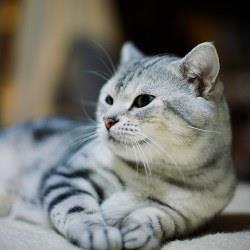

In [4]:
im=read_image('../images/cat.jpg')
im

In [5]:
print(resnet50.infer_single_image('../images/cat.jpg',5))

OrderedDict([(' n02124075\t埃及猫', (285, 0.91669977)), (' n02123159\t山猫', (282, 0.036665753)), (' n02123045\t虎斑猫', (281, 0.035495527)), (' n02128757\t雪豹', (289, 0.0038159543)), (' n02129604\t老虎', (292, 0.0013234711))])


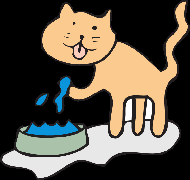

In [6]:
im=read_image('../images/manka.png')
im

In [7]:
print(resnet50.infer_single_image('../images/manka.png',5))

OrderedDict([(' n03595614\t運動衫', (610, 0.14498636)), (' n03666591\t點火器', (626, 0.13321188)), (' n03063599\t咖啡杯', (504, 0.08954001)), (' n03598930\t拼圖', (611, 0.05674034)), (' n06596364\t漫畫', (917, 0.050602384))])


In [8]:
data_provider=T.load_examples_data('animals')
data_provider.image_transform_funcs=[
                     random_center_crop(224,224,scale=(0.8,1.4)),
                     #原比例隨機縮放(正確縮放比例再乘上0.8~1.2之間隨機數)中央裁切至224,224
                     random_adjust_gamma(gamma=(0.8,1.2)),
                     #隨機調整圖片明暗gamma 0.6~1.4之間
                     random_adjust_contrast(scale=(0.8, 1.2)),
                     #隨機調整圖片對比度
                     normalize(0,255),#除以255
                     normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])] #透過imagenet像素均值標準差再做一次正規化
data_provider.minibatch_size=16

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
C:/Users/Allan/.trident/datasets/examples_animals
['cat', 'chipmunk', 'dog', 'fox', 'giraffe', 'guinea pig', 'hyena', 'reindeer', 'sikadeer', 'squirrel', 'weasel', 'wolf']
C:/Users/Allan/.trident/datasets/examples_animals/cat/*.*g
2766
C:/Users/Allan/.trident/datasets/examples_animals/chipmunk/*.*g
2829
C:/Users/Allan/.trident/datasets/examples_animals/dog/*.*g
3132
C:/Users/Allan/.trident/datasets/examples_animals/fox/*.*g
3191
C:/Users/Allan/.trident/datasets/examples_animals/giraffe/*.*g
3233
C:/Users/Allan/.trident/datasets/examples_animals/guinea pig/*.*g
2970
C:/Users/Allan/.trident/datasets/examples_animals/hyena/*.*g
2679
C:/Users/Allan/.trident/datasets/examples_animals/reindeer/*.*g
3158
C:/Users/Allan/.trident/datasets/examples_animals/sikadeer/*.*g
2857
C:/Users/Allan/.trident/datasets/examples_animals/squirrel/*.*g
2551
C:/Users/Allan/.trident/datasets/examples_

In [9]:
finetune_resnet50=resnet.ResNet50(include_top=True,
             pretrained=True,
             input_shape=(3, 224, 224),
             classes=12)


model file is already existing, donnot need download again.


In [10]:
finetune_resnet50.summary()

--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
first_block                              [-1, 64, 112, 112]                                   0         0.0         
batch_norm_54                            [-1, 64, 112, 112]    [64]                 [64]      128       2395904.0   
max_pool2d_8                             [-1, 64, 56, 56]                                     0         0.0         
layer1.0_0_conv                          [-1, 64, 56, 56]                                     0         0.0         
batch_norm_56                            [-1, 64, 56, 56]      [64]                 [64]      128       598976.0    
layer1.0_1_conv                          [-1, 64, 56, 56]                                     0         0.0         
batch_norm_57                            [-1, 64, 56

In [11]:
finetune_resnet50.model.trainable=False
finetune_resnet50.summary()

23532620 parameters have set untrainable
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
first_block                              [-1, 64, 112, 112]                                   0         0.0         
batch_norm_54                            [-1, 64, 112, 112]    [64]                 [64]      128       2395904.0   
max_pool2d_8                             [-1, 64, 56, 56]                                     0         0.0         
layer1.0_0_conv                          [-1, 64, 56, 56]                                     0         0.0         
batch_norm_56                            [-1, 64, 56, 56]      [64]                 [64]      128       598976.0    
layer1.0_1_conv                          [-1, 64, 56, 56]                                     0         0.0         
batch_norm_

In [12]:
finetune_resnet50.model.fc.trainable=True

finetune_resnet50.summary()

24588 parameters have set trainable
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
first_block                              [-1, 64, 112, 112]                                   0         0.0         
batch_norm_54                            [-1, 64, 112, 112]    [64]                 [64]      128       2395904.0   
max_pool2d_8                             [-1, 64, 56, 56]                                     0         0.0         
layer1.0_0_conv                          [-1, 64, 56, 56]                                     0         0.0         
batch_norm_56                            [-1, 64, 56, 56]      [64]                 [64]      128       598976.0    
layer1.0_1_conv                          [-1, 64, 56, 56]                                     0         0.0         
batch_norm_57   

In [13]:
#自訂callbacks
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_batch_end(self, training_context):
        if training_context['current_batch']==0:
            print(training_context['losses'])   #列印各個loss值
        if training_context['current_batch']==200:
            training_context['current_model'].layer4.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_batch']>0 and training_context['current_batch']%1000==0:
            training_context['optimizer'].lr=training_context['optimizer'].lr*0.5
            #每訓練1000批次，學習速率降一半
    

In [14]:
finetune_resnet50=finetune_resnet50\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(accuracy,topk=3,name='top3_accuracy')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_model_save_path('Models/finetune_resnet50.pth')
   

CrossEntropyLoss signature:[('output', [12]), ('target', [12])]
accuracy signature:[('output', [12]), ('target', [12])]
top3_accuracy signature:[('output', [12]), ('target', [12])]


![Alt text](../images/animals_overview.jpg)

![Alt text](../images/cutmix.png)

In [15]:
finetune_resnet50=finetune_resnet50\
    .with_callbacks(CutMixCallback(alpha=1,loss_criterion=CrossEntropyLoss,loss_weight=0.5))\
    .with_callbacks(MixupCallback(alpha=1,loss_criterion=CrossEntropyLoss,loss_weight=0.2))\
    .with_callbacks(CustomCallback())

plan=TrainingPlan()\
    .add_training_item(finetune_resnet50)\
    .with_data_loader(data_provider)\
    .repeat_epochs(3)\
    .within_minibatch_size(8)\
    .print_progress_scheduling(50,unit='batch')\
    .save_model_scheduling(100,unit='batch')\
    .display_loss_metric_curve_scheduling(500,unit='batch',imshow=True)

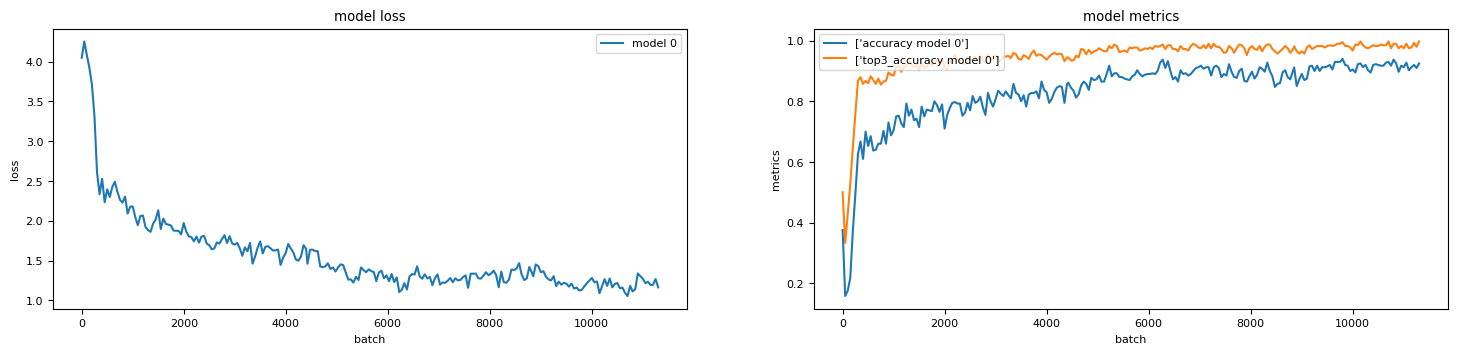

model 0      Step: 40s592ms | Loss: 1.226   | accuracy: 92.000% ,top3_accuracy: 98.250%  | learning rate: 9.766e-07 | epoch: 2  ( 2500/4427 )
model 0      Step: 42s38ms  | Loss: 1.191   | accuracy: 92.750% ,top3_accuracy: 97.250%  | learning rate: 9.766e-07 | epoch: 2  ( 2550/4427 )
model 0      Step: 41s446ms | Loss: 1.174   | accuracy: 91.000% ,top3_accuracy: 97.500%  | learning rate: 9.766e-07 | epoch: 2  ( 2600/4427 )
model 0      Step: 42s80ms  | Loss: 1.200   | accuracy: 92.500% ,top3_accuracy: 97.250%  | learning rate: 9.766e-07 | epoch: 2  ( 2650/4427 )
model 0      Step: 41s686ms | Loss: 1.208   | accuracy: 92.000% ,top3_accuracy: 98.500%  | learning rate: 9.766e-07 | epoch: 2  ( 2700/4427 )
model 0      Step: 40s565ms | Loss: 1.149   | accuracy: 92.000% ,top3_accuracy: 98.500%  | learning rate: 9.766e-07 | epoch: 2  ( 2750/4427 )
model 0      Step: 41s988ms | Loss: 1.304   | accuracy: 89.750% ,top3_accuracy: 98.500%  | learning rate: 9.766e-07 | epoch: 2  ( 2800/4427 )
model 

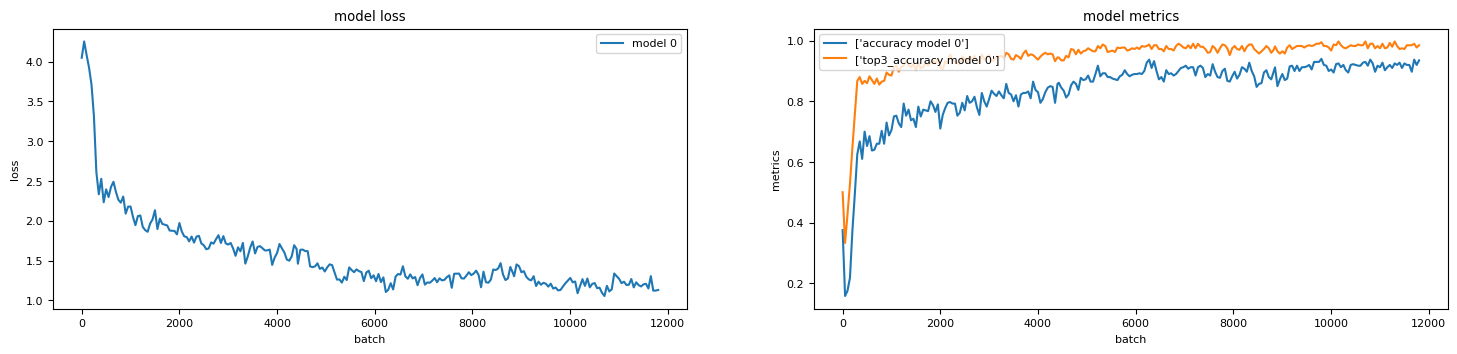

model 0      Step: 41s788ms | Loss: 1.267   | accuracy: 91.000% ,top3_accuracy: 98.250%  | learning rate: 9.766e-07 | epoch: 2  ( 3000/4427 )
learning rate changed! ( form 9.766e-07 to 4.883e-07)
model 0      Step: 41s568ms | Loss: 1.335   | accuracy: 90.500% ,top3_accuracy: 97.250%  | learning rate: 4.883e-07 | epoch: 2  ( 3050/4427 )
model 0      Step: 42s176ms | Loss: 1.243   | accuracy: 89.250% ,top3_accuracy: 96.750%  | learning rate: 4.883e-07 | epoch: 2  ( 3100/4427 )
model 0      Step: 43s366ms | Loss: 1.164   | accuracy: 91.000% ,top3_accuracy: 98.250%  | learning rate: 4.883e-07 | epoch: 2  ( 3150/4427 )
model 0      Step: 41s560ms | Loss: 1.146   | accuracy: 92.750% ,top3_accuracy: 97.750%  | learning rate: 4.883e-07 | epoch: 2  ( 3200/4427 )
model 0      Step: 43s13ms  | Loss: 1.254   | accuracy: 89.250% ,top3_accuracy: 96.750%  | learning rate: 4.883e-07 | epoch: 2  ( 3250/4427 )
model 0      Step: 43s715ms | Loss: 1.336   | accuracy: 89.500% ,top3_accuracy: 97.750%  | lea

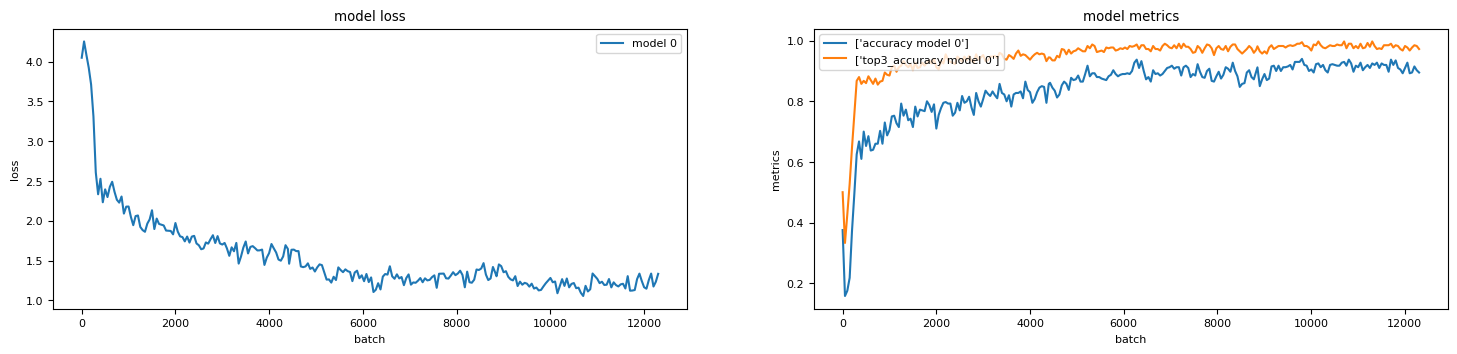

model 0      Step: 42s660ms | Loss: 1.287   | accuracy: 89.750% ,top3_accuracy: 97.250%  | learning rate: 4.883e-07 | epoch: 2  ( 3500/4427 )
model 0      Step: 42s626ms | Loss: 1.242   | accuracy: 91.250% ,top3_accuracy: 98.250%  | learning rate: 4.883e-07 | epoch: 2  ( 3550/4427 )
model 0      Step: 41s525ms | Loss: 1.338   | accuracy: 87.750% ,top3_accuracy: 97.500%  | learning rate: 4.883e-07 | epoch: 2  ( 3600/4427 )
model 0      Step: 42s282ms | Loss: 1.317   | accuracy: 88.000% ,top3_accuracy: 97.750%  | learning rate: 4.883e-07 | epoch: 2  ( 3650/4427 )
model 0      Step: 40s200ms | Loss: 1.360   | accuracy: 88.500% ,top3_accuracy: 97.000%  | learning rate: 4.883e-07 | epoch: 2  ( 3700/4427 )
model 0      Step: 42s960ms | Loss: 1.286   | accuracy: 89.000% ,top3_accuracy: 97.500%  | learning rate: 4.883e-07 | epoch: 2  ( 3750/4427 )
model 0      Step: 43s585ms | Loss: 1.222   | accuracy: 92.500% ,top3_accuracy: 97.250%  | learning rate: 4.883e-07 | epoch: 2  ( 3800/4427 )
model 

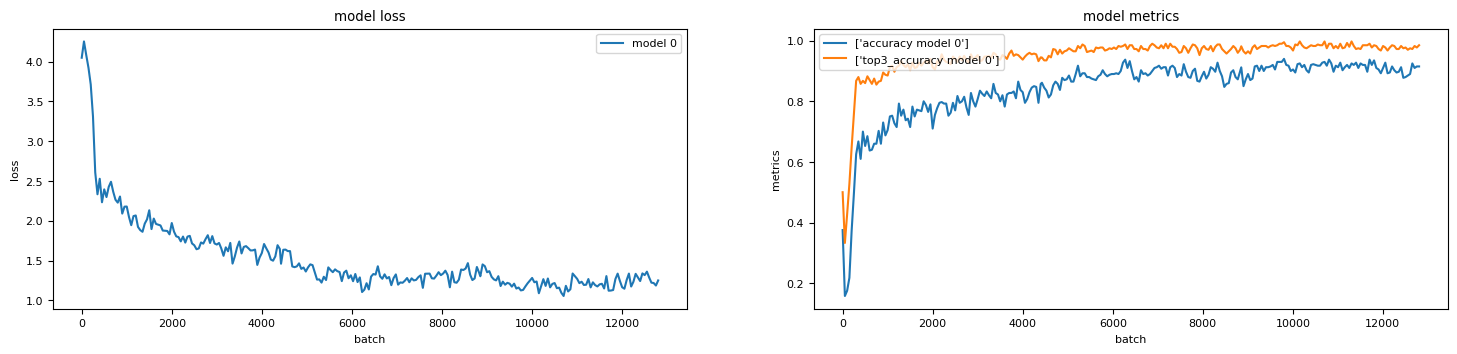

model 0      Step: 42s140ms | Loss: 1.318   | accuracy: 89.250% ,top3_accuracy: 97.500%  | learning rate: 4.883e-07 | epoch: 2  ( 4000/4427 )
learning rate changed! ( form 4.883e-07 to 2.441e-07)
model 0      Step: 41s641ms | Loss: 1.389   | accuracy: 84.750% ,top3_accuracy: 96.500%  | learning rate: 2.441e-07 | epoch: 2  ( 4050/4427 )
model 0      Step: 41s238ms | Loss: 1.324   | accuracy: 87.500% ,top3_accuracy: 96.750%  | learning rate: 2.441e-07 | epoch: 2  ( 4100/4427 )
model 0      Step: 39s718ms | Loss: 1.443   | accuracy: 88.000% ,top3_accuracy: 97.250%  | learning rate: 2.441e-07 | epoch: 2  ( 4150/4427 )
model 0      Step: 41s85ms  | Loss: 1.347   | accuracy: 88.000% ,top3_accuracy: 96.500%  | learning rate: 2.441e-07 | epoch: 2  ( 4200/4427 )
model 0      Step: 42s42ms  | Loss: 1.241   | accuracy: 90.000% ,top3_accuracy: 99.250%  | learning rate: 2.441e-07 | epoch: 2  ( 4250/4427 )
model 0      Step: 45s843ms | Loss: 1.325   | accuracy: 89.000% ,top3_accuracy: 97.500%  | lea

In [16]:
plan.start_now()


In [17]:
#finetune_resnet50.class_names=dataset.class_names['en-us']
finetune_resnet50.class_names=['貓 cat', '花栗鼠 chipmunk ', '狗 dog', '狐狸 fox', '長頸鹿 giraffe', '天竺鼠 guinea pig', '鬣狗 hyena', '馴鹿 reindeer', '梅花鹿 sikadeer', '松鼠 squirrel', '黃鼠狼 weasel', '狼 wolf']
print(finetune_resnet50.class_names)

['貓 cat', '花栗鼠 chipmunk ', '狗 dog', '狐狸 fox', '長頸鹿 giraffe', '天竺鼠 guinea pig', '鬣狗 hyena', '馴鹿 reindeer', '梅花鹿 sikadeer', '松鼠 squirrel', '黃鼠狼 weasel', '狼 wolf']


模型訓練好後，我們利用infer_single_image來看一下預測效果，首先是那隻手繪的貓，這次模型答對了，機率高達92%

OrderedDict([('貓 cat', (0, 0.9279644)), ('狗 dog', (2, 0.034741115)), ('松鼠 squirrel', (9, 0.01815735)), ('馴鹿 reindeer', (7, 0.010879905)), ('黃鼠狼 weasel', (10, 0.0032833791))])


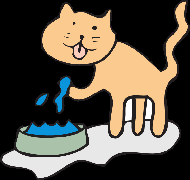

In [26]:
im=read_image('../images/manka.png')
print(finetune_resnet50.infer_single_image('../images/manka.png',5))
im

那扮成美國隊長的貓呢?抱歉，模型還是答錯了，不過課為可以發現模型對於沒把握，可能答錯這件事還是容易判斷的，你看他回答的結果中的最高機率選項都沒超過40%

OrderedDict([('狗 dog', (2, 0.3769929)), ('馴鹿 reindeer', (7, 0.34429127)), ('花栗鼠 chipmunk ', (1, 0.11697375))])


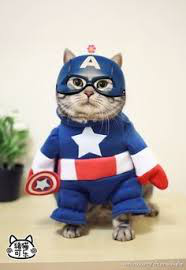

In [19]:
im=read_image('../images/captaincat.jpg')
print(finetune_resnet50.infer_single_image('../images/captaincat.jpg',topk=3))
im

接下來是我當時故意設計的超難題，非洲十萬年前石壁壁畫，而這次模型也答對了。

OrderedDict([('長頸鹿 giraffe', (4, 0.8182058)), ('鬣狗 hyena', (6, 0.11077866)), ('黃鼠狼 weasel', (10, 0.03566022))])


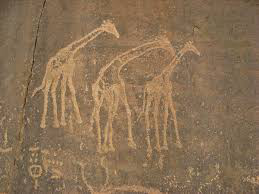

In [20]:
im=read_image('../images/africa.jpg')
print(finetune_resnet50.infer_single_image('../images/africa.jpg',topk=3))
im

剪紙屬於高度的抽象畫與變形，這次模型不算是答對，把它誤判成狼。

OrderedDict([('狼 wolf', (11, 0.69357765)), ('天竺鼠 guinea pig', (5, 0.094987154)), ('貓 cat', (0, 0.0554883))])


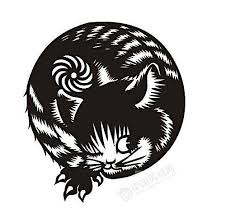

In [21]:
im=read_image('../images/paper.jpg')
print(finetune_resnet50.infer_single_image('../images/paper.jpg',topk=3))
im

大家熟悉的海賊王喬巴，至少馴鹿有出現在前三的選項。

OrderedDict([('狼 wolf', (11, 0.89995146)), ('馴鹿 reindeer', (7, 0.07738234)), ('貓 cat', (0, 0.004314715))])


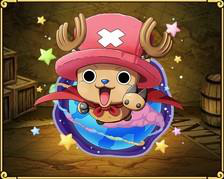

In [22]:
im=read_image('../images/joba.jpg')
print(finetune_resnet50.infer_single_image('../images/joba.jpg',topk=3))
im

機器會認為它是狗還是長頸鹿呢?答案是機器能判斷它是一隻扮成長頸鹿的狗。

OrderedDict([('狗 dog', (2, 0.5882838)), ('長頸鹿 giraffe', (4, 0.096057035)), ('天竺鼠 guinea pig', (5, 0.09438495))])


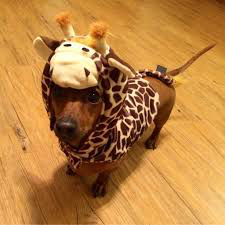

In [23]:
im=read_image('../images/fakegiraffe.jpg')
print(finetune_resnet50.infer_single_image('../images/fakegiraffe.jpg',topk=3))
im

這個像拖把的物體其實是稀有的長毛天竺鼠，機器也答對了。

OrderedDict([('天竺鼠 guinea pig', (5, 0.794581)), ('貓 cat', (0, 0.067226365)), ('狼 wolf', (11, 0.035700236))])


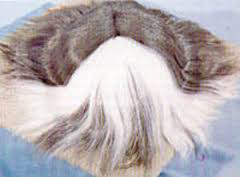

In [27]:
im=read_image('../images/longhair.jpg')#這是稀有品種長毛天竺鼠
print(finetune_resnet50.infer_single_image('../images/longhair.jpg',topk=3))
im